In [1]:
#0: imports

import uproot 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from dataAnalyse import CCV2
from torch_geometric.data import DataLoader 
from model_3DEC import Net
from torch_geometric.nn import knn_graph

import numpy as np
import time
from Imports import Aggloremative, calculate_reco_to_sim_score, calculate_sim_to_reco_score, calculate_all_event_scores
import awkward as ak

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
#1: Load Data + Model
#1.1: Load Data
testpath = "/vols/cms/mm1221/Data/100k/5e/test/"  
data_test = CCV2(testpath, max_events=99) #<-- change this max_events and if want < 500 change step_size in CCV2.

test_loader = DataLoader(data_test, batch_size=1, shuffle=False, follow_batch=['x'])

GT_ind = data_test.stsCP_vertices_indexes

print("LENGTH OF GT_ind", len(GT_ind))

data_path = '/vols/cms/mm1221/Data/100k/5e/test/raw/test.root'
data_file = uproot.open(data_path)

Track_ind = data_file['tracksters;1']['vertices_indexes'].array()

#GT_ind = data_file['simtrackstersCP;3']['vertices_indexes'].array()
#GT_mult = data_file['simtrackstersCP;3']['vertices_multiplicity'].array()

#GT_bc = data_file['simtrackstersCP;3']['barycenter_x'].array()
energies = data_file['clusters;3']['energy'].array()
LC_x = data_file['clusters;3']['position_x'].array()
LC_y = data_file['clusters;3']['position_y'].array()
LC_z = data_file['clusters;3']['position_z'].array()
LC_eta = data_file['clusters;3']['position_eta'].array()
#MT_ind = data_file['trackstersMerged;2']['vertices_indexes'].array()




#1.2: Load Model

model = Net(32, 64, 128)
checkpoint= torch.load('/vols/cms/er421/hgcal/code/code/elec5New/results/3DEC_100K_new/results_lr0.001_bs64_hd32_k64_temp0.1_cd128/best_model.pt',  map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)  
model.eval()  

### Loading data


  0%|                                                                                             | 0/1 [00:04<?, ?it/s]

Reached 99!
LENGTH OF GT_ind 100



/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Net(
  (lc_encode): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ELU(alpha=1.0)
  )
  (conv1): DynamicEdgeConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ELU(alpha=1.0)
  ), k=64)
  (conv2): DynamicEdgeConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ELU(alpha=1.0)
  ), k=64)
  (conv3): DynamicEdgeConv(nn=Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ELU(alpha=1.0)
  ), k=64)
  (output): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=16, out_features=128, bias=True)
  )
)

In [4]:
"""
for i, data in enumerate(test_loader):
    print(f"Batch {i}, Data Shape: {data.x.shape}, Batch Shape: {data.x_batch.shape}")
print("All batches loaded successfully.")
"""

'\nfor i, data in enumerate(test_loader):\n    print(f"Batch {i}, Data Shape: {data.x.shape}, Batch Shape: {data.x_batch.shape}")\nprint("All batches loaded successfully.")\n'

In [13]:
"""
# computing predictions
all_predictions = []  
for i, data in enumerate(test_loader):
    print(i)
    predictions = model(data.x, data.x_batch)
    all_predictions.append(predictions[0].detach().cpu().numpy())
all_predictions = np.array(all_predictions)
"""

'\n# computing predictions\nall_predictions = []  \nfor i, data in enumerate(test_loader):\n    print(i)\n    predictions = model(data.x, data.x_batch)\n    all_predictions.append(predictions[0].detach().cpu().numpy())\nall_predictions = np.array(all_predictions)\n'

### 1. Efficiency against Purity

In [17]:
import time
import numpy as np
import matplotlib.pyplot as plt

# --- Define a modified calculate_metrics() that also returns the num trackster ratio ---
def calculate_metrics(df, model_name):
    # ----- Efficiency Calculation -----
    cp_valid = df.dropna(subset=['cp_id']).copy()
    cp_grouped = cp_valid.groupby(['event_index', 'cp_id'])
    cp_associated = cp_grouped['sim_to_reco_score'].min() < 0.2
    num_associated_cp = cp_associated.sum()
    total_cp = cp_associated.count()
    efficiency = num_associated_cp / total_cp if total_cp > 0 else 0

    # ----- Purity Calculation -----
    tst_valid = df.dropna(subset=['trackster_id']).copy()
    tst_grouped = tst_valid.groupby(['event_index', 'trackster_id'])
    tst_associated = tst_grouped['reco_to_sim_score'].min() < 0.2
    num_associated_tst = tst_associated.sum()
    total_tst = tst_associated.count()
    purity = num_associated_tst / total_tst if total_tst > 0 else 0

    # ----- Average Energy Ratio Calculation -----
    low_score_mask = df['sim_to_reco_score'] < 0.2
    low_score_events = df[low_score_mask]
    if not low_score_events.empty:
        avg_energy_ratio = (low_score_events['trackster_energy'] / low_score_events['cp_energy']).mean()
    else:
        avg_energy_ratio = 0

    # ----- Num Trackster Ratio Calculation -----
    # Here we compute the average number of tracksters per event and CP per event.
    tst_per_event = tst_valid.groupby('event_index')['trackster_id'].nunique().mean()
    cp_per_event  = cp_valid.groupby('event_index')['cp_id'].nunique().mean()
    num_trackster_ratio = tst_per_event / cp_per_event if cp_per_event > 0 else 0

    print(f"\nModel: {model_name}")
    print(f"Efficiency: {efficiency:.4f} ({num_associated_cp} associated CPs out of {total_cp} total CPs)")
    print(f"Purity: {purity:.4f} ({num_associated_tst} associated Tracksters out of {total_tst} total Tracksters)")
    print(f"Num Tracksters Ratio: {num_trackster_ratio:.4f}")
    print(f"Average Energy Ratio: {avg_energy_ratio:.4f}")

    return {
        'efficiency': efficiency,
        'purity': purity,
        'avg_energy_ratio': avg_energy_ratio,
        'num_trackster_ratio': num_trackster_ratio
    }

# --- Grid search over distance thresholds ---

# Choose a set of candidate thresholds; adjust the range and resolution as needed.
threshold_values = np.linspace(0.1, 2.0, 10)
results_list = []

# Precompute predictions for efficiency.
all_predictions = []  
all_cluster_idx = []
start_time = time.time()
for i, data in enumerate(test_loader):
    predictions = model(data.x, data.x_batch)
    all_predictions.append(predictions[0].detach().cpu().numpy())
    all_cluster_idx.append(data.idx[0].flatten()) # extract layer cluster indices corresponding to all_predictions after 
    # you've applied filtering for unique lcs
    
all_predictions = np.array(all_predictions)
all_cluster_idx = np.array(all_cluster_idx)
# (Assume Track_ind is available; see your original code.)

efficiencies = []
purities = []

for t in threshold_values:
    print(f"\nTesting threshold = {t:.2f}")
    # --- 3. Cluster using the threshold ---
    all_cluster_labels = Aggloremative(all_predictions, threshold = t)
    
    
    # --- 4. Reconstruct tracksters ---
    recon_ind = []
    for event_idx, labels in enumerate(all_cluster_labels):
        event_clusters = {}
        # Here, each event has a list of clusters; for each cluster, add the corresponding indices.
        for cluster_idx, cluster_label in enumerate(labels):
            if cluster_label not in event_clusters:
                event_clusters[cluster_label] = []
            # Extend using your precomputed Track_ind (adjust according to your code)
            event_clusters[cluster_label].append(all_cluster_idx[event_idx][cluster_idx])
        # Sort clusters by label and store.
        recon_ind.append([event_clusters[label] for label in sorted(event_clusters.keys())])
    
    
    # --- 5. Build the DataFrame of event scores ---
    df_CL_temp = calculate_all_event_scores(GT_ind, energies, recon_ind,
                                            LC_x, LC_y, LC_z, LC_eta,
                                            num_events = 100) #<--- change this num_events to the same number that 
    #is loaded by CCV2.
    
    # --- 6. Compute metrics ---
    metrics = calculate_metrics(df_CL_temp, f"Threshold {t:.2f}")
    efficiencies.append(metrics['efficiency'])
    purities.append(metrics['purity'])

    #avg_energy_ratio = metrics['avg_energy_ratio']
    #num_ratio = metrics['num_trackster_ratio']



Testing threshold = 0.10

Model: Threshold 0.10
Efficiency: 0.5930 (169 associated CPs out of 285 total CPs)
Purity: 0.8269 (1333 associated Tracksters out of 1612 total Tracksters)
Num Tracksters Ratio: 5.6561
Average Energy Ratio: 1.3832

Testing threshold = 0.31

Model: Threshold 0.31
Efficiency: 0.8175 (233 associated CPs out of 285 total CPs)
Purity: 0.8028 (582 associated Tracksters out of 725 total Tracksters)
Num Tracksters Ratio: 2.5439
Average Energy Ratio: 2.2732

Testing threshold = 0.52

Model: Threshold 0.52
Efficiency: 0.8877 (253 associated CPs out of 285 total CPs)
Purity: 0.7910 (371 associated Tracksters out of 469 total Tracksters)
Num Tracksters Ratio: 1.6456
Average Energy Ratio: 2.6221

Testing threshold = 0.73

Model: Threshold 0.73
Efficiency: 0.9053 (258 associated CPs out of 285 total CPs)
Purity: 0.7899 (282 associated Tracksters out of 357 total Tracksters)
Num Tracksters Ratio: 1.2526
Average Energy Ratio: 3.0017

Testing threshold = 0.94

Model: Threshol

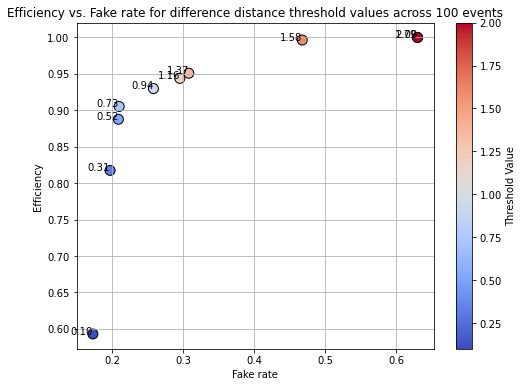

In [18]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(1-np.array(purities), efficiencies, c=threshold_values, cmap='coolwarm', edgecolors='k', s=100)

# Add labels
for i, t in enumerate(threshold_values):
    plt.text(1-np.array(purities[i]), efficiencies[i], f"{t:.2f}", fontsize=10, ha='right')

plt.xlabel("Fake rate")
plt.ylabel("Efficiency")
plt.title("Efficiency vs. Fake rate for difference distance threshold values across 100 events")
plt.colorbar(label="Threshold Value")  # Show color scale for thresholds
plt.grid(True)
plt.show()

### 2. Point cloud


Model: Threshold 0.94, Linkage single
Efficiency: 0.0175 (5 associated CPs out of 285 total CPs)
Purity: 1.0000 (41714 associated Tracksters out of 41714 total Tracksters)
Num Tracksters Ratio: 146.3649
Average Energy Ratio: 0.5068


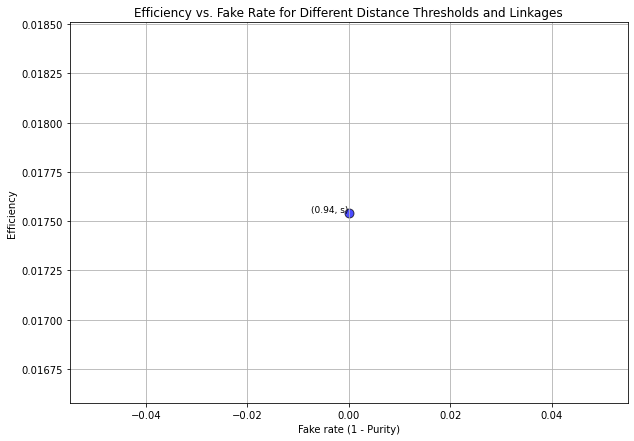

In [9]:
import time
import numpy as np
import matplotlib.pyplot as plt
from itertools import product


# --- Define a modified calculate_metrics() that also returns the num trackster ratio ---
def calculate_metrics(df, model_name):
    # ----- Efficiency Calculation -----
    cp_valid = df.dropna(subset=['cp_id']).copy()
    cp_grouped = cp_valid.groupby(['event_index', 'cp_id'])
    cp_associated = cp_grouped['sim_to_reco_score'].min() < 0.2
    num_associated_cp = cp_associated.sum()
    total_cp = cp_associated.count()
    efficiency = num_associated_cp / total_cp if total_cp > 0 else 0

    # ----- Purity Calculation -----
    tst_valid = df.dropna(subset=['trackster_id']).copy()
    tst_grouped = tst_valid.groupby(['event_index', 'trackster_id'])
    tst_associated = tst_grouped['reco_to_sim_score'].min() < 0.2
    num_associated_tst = tst_associated.sum()
    total_tst = tst_associated.count()
    purity = num_associated_tst / total_tst if total_tst > 0 else 0

    # ----- Average Energy Ratio Calculation -----
    low_score_mask = df['sim_to_reco_score'] < 0.2
    low_score_events = df[low_score_mask]
    if not low_score_events.empty:
        avg_energy_ratio = (low_score_events['trackster_energy'] / low_score_events['cp_energy']).mean()
    else:
        avg_energy_ratio = 0

    # ----- Num Trackster Ratio Calculation -----
    # Here we compute the average number of tracksters per event and CP per event.
    tst_per_event = tst_valid.groupby('event_index')['trackster_id'].nunique().mean()
    cp_per_event  = cp_valid.groupby('event_index')['cp_id'].nunique().mean()
    num_trackster_ratio = tst_per_event / cp_per_event if cp_per_event > 0 else 0

    print(f"\nModel: {model_name}")
    print(f"Efficiency: {efficiency:.4f} ({num_associated_cp} associated CPs out of {total_cp} total CPs)")
    print(f"Purity: {purity:.4f} ({num_associated_tst} associated Tracksters out of {total_tst} total Tracksters)")
    print(f"Num Tracksters Ratio: {num_trackster_ratio:.4f}")
    print(f"Average Energy Ratio: {avg_energy_ratio:.4f}")

    return {
        'efficiency': efficiency,
        'purity': purity,
        'avg_energy_ratio': avg_energy_ratio,
        'num_trackster_ratio': num_trackster_ratio
    }

# --- Define hyperparameters ---
threshold_values = np.linspace(0.1, 2.0, 10)  # Distance thresholds
linkage_types = ['ward', 'average', 'complete', 'single']  # Linkage methods


# Precompute predictions for efficiency.
all_predictions = []  
all_cluster_idx = []
start_time = time.time()
for i, data in enumerate(test_loader):
    predictions = model(data.x, data.x_batch)
    all_predictions.append(predictions[0].detach().cpu().numpy())
    all_cluster_idx.append(data.idx[0].flatten()) # extract layer cluster indices corresponding to all_predictions after 
    # you've applied filtering for unique lcs
    
all_predictions = np.array(all_predictions)
all_cluster_idx = np.array(all_cluster_idx)
# (Assume Track_ind is available; see your original code.)


results_list2 = []  # Store results

# --- 3. Loop over both hyperparameters ---

    
# --- 4. Perform Agglomerative Clustering ---
all_cluster_labels = Aggloremative(all_predictions, metric="euclidean", threshold=0.94, linkage='average')

# --- 5. Reconstruct tracksters ---
recon_ind = []
for event_idx, labels in enumerate(all_cluster_labels):
    event_clusters = {}
    for cluster_idx, cluster_label in enumerate(labels):
        if cluster_label not in event_clusters:
            event_clusters[cluster_label] = []
        event_clusters[cluster_label].append(all_cluster_idx[event_idx][cluster_idx])
    recon_ind.append([event_clusters[label] for label in sorted(event_clusters.keys())])

# --- 6. Compute event scores ---
df_CL_temp = calculate_all_event_scores(GT_ind, energies, recon_ind,
                                        LC_x, LC_y, LC_z, LC_eta,
                                        num_events=100)

# --- 7. Compute metrics ---
metrics = calculate_metrics(df_CL_temp, f"Threshold 0.94, Linkage {linkage}")
results_list2.append({
    'threshold': 0.94,
    'linkage': linkage,
    'efficiency': metrics['efficiency'],
    'purity': metrics['purity'],
    'fake_rate': 1 - metrics['purity']
})

# Convert results to NumPy arrays for plotting
efficiencies = np.array([res['efficiency'] for res in results_list2])
fake_rates = np.array([res['fake_rate'] for res in results_list2])

# --- 8. Plot results ---
plt.figure(figsize=(10, 7))

# Use a single uniform style for all points
plt.scatter(fake_rates, efficiencies, color='blue', edgecolors='k', s=80, alpha=0.7)

# Annotate each point with (threshold, linkage)
for i, res in enumerate(results_list2):
    plt.text(fake_rates[i], efficiencies[i], f"({res['threshold']:.2f}, {res['linkage'][0]})", 
             fontsize=9, ha='right', color='black')

# Labels and formatting
plt.xlabel("Fake rate (1 - Purity)")
plt.ylabel("Efficiency")
plt.title("Efficiency vs. Fake Rate for Different Distance Thresholds and Linkages")
plt.grid(True)

plt.show()


### 3. Efficiency vs number of constituent LCs in reconstructed trackster

### 4. Relation between efficiency, purity, num_tracksters/num_caloparticles (oversplitting) per event
Plot num_tracksters ratio against distance_threshold and see that the purity/efficiency balance is determined by number of tracksters produced.

In [ ]:
all_cluster_labels = Aggloremative(all_predictions, threshold = 1)
    
efficiencies = []
purities = []
num_tst_ratio = []


# --- 4. Reconstruct tracksters ---
recon_ind = []
for event_idx, labels in enumerate(all_cluster_labels):
    event_clusters = {}
    # Here, each event has a list of clusters; for each cluster, add the corresponding indices.
    for cluster_idx, cluster_label in enumerate(labels):
        if cluster_label not in event_clusters:
            event_clusters[cluster_label] = []
        # Extend using your precomputed Track_ind (adjust according to your code)
        event_clusters[cluster_label].append(all_cluster_idx[event_idx][cluster_idx])
    # Sort clusters by label and store.
    recon_ind.append([event_clusters[label] for label in sorted(event_clusters.keys())])


# --- 5. Build the DataFrame of event scores ---
df_CL_temp = calculate_all_event_scores(GT_ind, energies, recon_ind,
                                        LC_x, LC_y, LC_z, LC_eta,
                                        num_events = 100) #<--- change this num_events to the same number that 
#is loaded by CCV2.

# --- 6. Compute metrics ---
metrics = calculate_metrics(df_CL_temp, "Threshold 1")
efficiencies.append(metrics['efficiency'])
purities.append(metrics['purity'])
num_tst_ratio.append(metrics['num_trackster_ratio'])

